In [1]:
import numpy as np
import scipy.linalg as spla
import scipy.sparse.linalg as spsp
import matplotlib.pyplot as plt
import dask.array as da
import dask
from dask.distributed import Client, LocalCluster
from dask_glm.algorithms import admm, gradient_descent
import verde as vd

In [2]:
client = Client(
    LocalCluster(n_workers=1, threads_per_worker=8, memory_limit="8Gb")
)
client

Client Scheduler: tcp://127.0.0.1:40361 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 8.00 GB


In [519]:
data = vd.datasets.CheckerBoard().scatter(size=10_000).astype("float32")
east, north = data.easting.values, data.northing.values
coordinates = (east, north)
d = data.scalars# + np.random.normal(scale=1, size=data.shape[0])
data

,northing,easting,scalars
0,-1258.660034,2744.067627,-575.521606
1,-4098.986328,3575.946777,-270.859253
2,-3054.884277,3013.816895,168.509460
3,-4811.999023,2724.416016,476.014404
4,-4941.061523,2118.273926,-809.869873
...,...,...,...
9995,-1259.127441,2752.234131,-592.162659
9996,-3508.666992,1985.756714,790.000427
9997,-2767.721191,3792.147705,-82.685944
9998,-3199.366943,118.937134,-54.721565


In [520]:
def scale(x):
    scale_ = np.nanstd(x, axis=0)
    scale_[np.isclose(scale_, 0)] = 1
    return x/scale_, scale_

def square_chunk(size, chunk):
    c = 1
    for n in range(1, size):
        if size % n == 0:
            c = n
        if n > 1*chunk:
            print("too big")
            break
    return c

def skinny_chunk(size, chunk):
    c = size*chunk//chunk**2
    return (size, size//c)


In [521]:
mindist = 1e3
damp = 1e-1
size = d.size
chunk = "100Mb"
deast, dnorth, dd = [
    da.from_array(i, chunks=chunk) for i in (east, north, d)
]

In [509]:
%%time
A, s = scale(vd.Spline(mindist=mindist).jacobian(coordinates, coordinates, dtype="float32"))
#p = spla.solve(A.T@A + damp*np.eye(size), A.T@d)
p = cg(A.T@A + damp*np.eye(size), A.T@d, np.zeros(size), tol=1e-10)

CPU times: user 383 ms, sys: 78.7 ms, total: 462 ms
Wall time: 99.6 ms


84.57877006868904


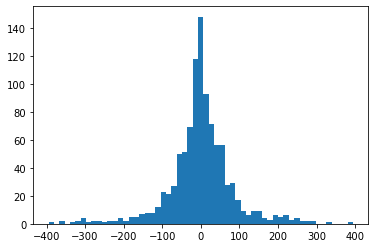

In [510]:
r = d - A.dot(p)
print(r.std())
plt.hist(r, bins="auto")
plt.show()

In [522]:
def dask_green(e, n, md):
    d = da.sqrt(e**2 + n**2) + md
    return (d**2) * (da.log(d) - 1)

def jacobian_dask(e, n, pe, pn, md):
    A = dask_green(
        e[np.newaxis].T - pe,
        n[np.newaxis].T - pn,
        md
    )
    return A

def scale_dask(x):
    scale_ = da.nanstd(x, axis=0)
    scale_[da.isclose(scale_, 0)] = 1
    return x/scale_, scale_

def steepest(jacobian, data, params, damp=0, maxit=100, maxsteps=20, step_size=1, armijo=0.1, tol=1e-5):
    residuals = data - jacobian.dot(params) 
    misfit = ((residuals**2).sum() + damp*(params**2).sum())
    #params, misfit, residuals = dask.compute(params, misfit, residuals)
    backtrack = 0.5
    step_growth = 1.25
    for iteration in range(maxit):
        gradient = -jacobian.T.dot(residuals) + damp*params
        #gradient = gradient.persist()
        # Calculate now to avoid computing inside the loop
        gradient_norm = (gradient ** 2).sum()
        #gradient_norm = gradient_norm.compute()
        # Determine the best step size
        for i in range(maxsteps):
            update = step_size*gradient
            new_params = params - update
            new_residuals = data - jacobian.dot(new_params)
            new_misfit = (new_residuals**2).sum() + damp*(new_params**2).sum()
            #new_misfit = new_misfit.compute()
            armijo_tol = armijo*step_size*gradient_norm
            if misfit - new_misfit >= armijo_tol:
                break
            step_size *= backtrack
        else:
            print("stagnation", iteration)
            break
        change_rate = abs((new_misfit - misfit) / misfit)
        params, residuals, misfit = new_params, new_residuals, new_misfit
        #params, residuals = dask.persist(params, residuals)
        print(
            "it:", iteration,
            "step_it:", i,
            "step_size:", step_size, 
            "change:", change_rate, 
            "misfit:", misfit, 
            "armijo:", armijo_tol, 
        )
        step_size *= step_growth
        if change_rate < tol:
            break
    else:
        print("maxit")
    return params


def cg(X, y, c0, M=None, tol=1e-5):
    c = c0
    r = y - X.dot(c)
    rtr = (r ** 2).sum()
    rtr = rtr.compute()
    p = r
    for i in range(X.shape[0]):
        Xp = X.dot(p)
        Xp = Xp.persist()
        alpha = rtr / (p * Xp).sum()
        c = c + alpha*p
        r = r - alpha*Xp
        rtr_old = rtr
        rtr = (r ** 2).sum()
        rtr = rtr.compute()
        if rtr < tol**2:
            break
        beta = rtr/rtr_old
        p = r + beta*p
    return c
        

In [ ]:
%%time
B, scale_ = scale_dask(jacobian_dask(deast, dnorth, deast, dnorth, mindist))
hessian = B.T@B 
gradient = B.T@dd
hessian = hessian + damp*da.eye(size, chunks=chunk, dtype="float32")
H = hessian
#H = spsp.interface.MatrixLinearOperator(hessian)
precond = da.diag(1/da.diagonal(hessian))
#M = spsp.interface.MatrixLinearOperator(precond)
M = precond
dask.persist(hessian, gradient, precond)
pa, info = cg(H, gradient, c0=da.zeros(size, chunks=B.chunksize[0]), tol=1e-5, M=M)
print(info)

distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [500]:
r = (dd - B.dot(pa)).compute()
print(r.std())
plt.hist(r, bins="auto")
plt.show()

ValueError: Chunks do not add up to shape. Got chunks=((1000,),), shape=(3,)

In [392]:
size = 10000
chunk = "100Mb"
da.random.seed(10)
X = da.random.uniform(size=(2*size, size), chunks=chunk).astype("float32")
#X, _ = scale_dask(X)
c = da.random.uniform(size=size, chunks=X.chunksize[0]).astype("float32")
noise = da.random.normal(scale=1, size=2*size)
y = X.dot(c) #+ noise
params = da.zeros(size, dtype="float32")
X, y, c = dask.persist(X, y, c)
print(X.chunks, c.chunks)

((2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500), (2500, 2500, 2500, 2500)) ((2500, 2500, 2500, 2500),)


In [393]:
X, y, params, noise = dask.compute(X, y, params, noise)

In [396]:
noise

array([ 0.4358495 , -1.34858766, -0.92698775, ...,  0.53855001,
        1.34240625, -1.08864318])

In [395]:
y

array([2502.98  , 2517.5105, 2478.9043, ..., 2507.117 , 2503.9458,
       2527.2837], dtype=float32)

In [ ]:
%%time


In [371]:
%%time
c_ = steepest(X, y, params, damp=0, step_size=1, maxsteps=100, maxit=100, armijo=1e-1, tol=1e-5)

it: 0 step_it: 25 step_size: 2.9802322387695312e-08 change: 0.7596292629735495 misfit: 30186933441.297195 armijo: 18715298895.41595
it: 1 step_it: 0 step_size: 3.725290298461914e-08 change: 0.25550492945180703 misfit: 22474023142.01216 armijo: 5623063646.243519
it: 2 step_it: 1 step_size: 2.3283064365386963e-08 change: 0.9729539776666586 misfit: 607832931.8188931 armijo: 2616422654.5394545
it: 3 step_it: 0 step_size: 2.9103830456733704e-08 change: 0.7908320260885606 misfit: 127139182.82520795 armijo: 88255615.18474178
it: 4 step_it: 0 step_size: 3.637978807091713e-08 change: 0.3253167245457864 misfit: 85778680.3070834 armijo: 22872990.011174407
it: 5 step_it: 1 step_size: 2.2737367544323206e-08 change: 0.9651518375111336 misfit: 2989229.389421754 armijo: 9593025.73840708
it: 6 step_it: 0 step_size: 2.8421709430404007e-08 change: 0.4357309791215871 misfit: 1686729.5407499892 armijo: 225021.3153489967
it: 7 step_it: 0 step_size: 3.552713678800501e-08 change: 0.06626659146324178 misfit: 1

In [372]:
np.testing.assert_allclose(c.compute(), c_)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatch: 100%
Max absolute difference: 0.50045182
Max relative difference: 1.00214754
 x: array([0.566928, 0.954181, 0.643801, ..., 0.660968, 0.116701, 0.177151],
      dtype=float32)
 y: array([0.506047, 0.503291, 0.502823, ..., 0.504476, 0.502794, 0.494327])

In [181]:
%%time
B, scale_ = scale_dask(jacobian_dask(deast, dnorth, deast, dnorth, mindist))
B, dd = dask.persist(B, dd)
#client.rebalance([B, dd])
pa = steepest(B, dd, damp=1e0, beta=0.1)

stagnation 0
CPU times: user 3 s, sys: 170 ms, total: 3.17 s
Wall time: 4.54 s


500.29044


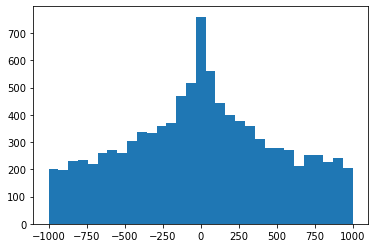

In [179]:
r = d - B.dot(pa).compute()
print(r.std())
plt.hist(r, bins="auto")
plt.show()

In [137]:
np.testing.assert_allclose(B.compute(), A, rtol=1e-3)

In [138]:
np.testing.assert_allclose(B.dot(pa).compute(), A.dot(p), rtol=1e-3)

AssertionError: 
Not equal to tolerance rtol=0.001, atol=0

Mismatch: 100%
Max absolute difference: 1008.60939771
Max relative difference: 920.12044231
 x: array([ 6.594849,  7.068853,  4.835266, ...,  4.81286 , 15.18896 ,
        5.65562 ], dtype=float32)
 y: array([-577.05969 , -268.589054,  167.631707, ...,  -87.984329,
        -62.036079,   10.537311])

array([[10.451519 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  4.543565 ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  4.9909296, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  1.0119445,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  3.3708858,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         1.1887013]], dtype=float32)

In [469]:
np.random.seed(10)
c = np.random.uniform(size=1000)
X = np.empty((size, c.size), dtype="float32")
for i in range(c.size):
    X[:, i] = np.linspace(*np.random.uniform(1, 1000, 2), size, dtype="float32")
#X = da.from_array(X, chunks=chunk)
y = X.dot(c)
Xs, s_ = scale(X)
#Xs, s_ = scale_dask(X)
#Xs, y = dask.persist(Xs, y)

In [470]:
X

array([[348.9816  , 460.17755 , 204.44319 , ..., 704.3452  , 138.92706 ,
        740.2849  ],
       [349.02762 , 460.19418 , 204.43219 , ..., 704.2787  , 138.9317  ,
        740.303   ],
       [349.07364 , 460.21082 , 204.4212  , ..., 704.21216 , 138.93633 ,
        740.3211  ],
       ...,
       [809.0618  , 626.4649  ,  94.60371 , ...,  39.194355, 185.252   ,
        921.08325 ],
       [809.10785 , 626.48157 ,  94.59272 , ...,  39.12782 , 185.25664 ,
        921.1013  ],
       [809.1539  , 626.49817 ,  94.581726, ...,  39.061283, 185.26128 ,
        921.11945 ]], dtype=float32)

In [478]:
%%time
hessian = Xs.T @ Xs + 1e2*da.eye(c.size, chunks=chunk, dtype="float32")
gradient = Xs.T @ y
#gradient = gradient.rechunk(new_chunk)
#hessian = hessian.rechunk(new_chunk)
#hessian = hessian 
#dask.persist(hessian, gradient)
#pa = da.linalg.solve(hessian, gradient).compute()
H = spsp.interface.MatrixLinearOperator(hessian)
precond = da.diag(1/da.diagonal(hessian))
M = spsp.interface.MatrixLinearOperator(precond)
c_, info = spsp.cg(H, gradient, tol=1e-5, M=M)
c_ = c_/s_
print(info)
#del hessian, gradient, H

0
CPU times: user 754 ms, sys: 435 ms, total: 1.19 s
Wall time: 448 ms


In [479]:
np.testing.assert_allclose(c, c_)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatch: 100%
Max absolute difference: 26.41198685
Max relative difference: 2.48683652
 x: array([0.771321, 0.020752, 0.633648, 0.748804, 0.498507, 0.224797,
       0.198063, 0.760531, 0.169111, 0.08834 , 0.68536 , 0.953393,
       0.003948, 0.512192, 0.812621, 0.612526, 0.721755, 0.291876,...
 y: array([ 0.441351,  0.484032,  1.639996,  0.355034,  0.58941 ,  0.322747,
        0.373039,  0.570651,  0.532271,  0.395528,  0.78547 ,  0.90131 ,
        0.57415 ,  0.56335 ,  0.719912,  0.893827,  0.555229,  0.424275,...

In [382]:
precond.compute()

array([[10.451519 ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  4.543565 ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  4.9909296, ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  1.0119445,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  3.3708858,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         1.1887013]], dtype=float32)

In [ ]:
%%time
B, scale_ = scale_dask(jacobian_dask(deast, dnorth, deast, dnorth, mindist))
hessian = B.T@B 
gradient = B.T@y
#gradient = gradient.rechunk(new_chunk)
#hessian = hessian.rechunk(new_chunk)
hessian = hessian + damp*da.eye(size, chunks=chunk, dtype="float32")
dask.persist(hessian, gradient, B)
client.rebalance([hessian, gradient, B])
#pa = da.linalg.solve(hessian, gradient).compute()
H = spsp.interface.MatrixLinearOperator(hessian)
pa, info = spsp.cg(H, gradient, tol=1e-3)
pa_ = p
print(info)